# GAPF for the UCI Adult Data Set

In [239]:
import torch
import torch.utils.data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

device = torch.device('cpu')

In [240]:
data = pd.read_csv("./data/adult.data", sep=", ")
data.head()

/home/alex/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [241]:
X = data.drop(['class', 'fnlwgt', 'capital-loss', 'capital-gain'], axis=1)

In [242]:
encoders = {}
X_num = X.copy()

for col in X_num.columns.tolist():
    if X_num[col].dtype == object:
        encoders[col] = preprocessing.LabelEncoder().fit(X_num[col])
        X_num[col] = encoders[col].transform(X_num[col])
X_num = X_num.drop(['race'], axis=1)

y = data['class'].copy()
y = y.replace("<=50K", 0)
y = y.replace(">50K", 1)

s = encoders['race'].transform(X['race'])

## Create Tensors

In [243]:
X_tensor = torch.tensor(X_num.values, device=device).double()
noise = torch.randn([X_tensor.shape[0], 5], device=device).double()
X_noised = torch.cat((X_tensor, noise), 1)

s_tensor = torch.tensor(s, device=device).double().unsqueeze(1)
y_tensor = torch.tensor(y.values, device=device).double().unsqueeze(1)
print("X", X_tensor.shape, "X_noised", X_noised.shape, "s", s.shape, "y", y.shape)

X torch.Size([32561, 10]) X_noised torch.Size([32561, 15]) s (32561,) y (32561,)


## Create Models

Since we only have 10 features, only append a size 5 vector of noise

In [244]:
model_gen = torch.nn.Sequential(
          # Layer 1 - 15 -> 128
          torch.nn.Linear(15, 128),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(128),
          # Layer 2 - 128 -> 254
          torch.nn.Linear(128, 256),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(256),
          # Layer 3 - 256 -> 256
          torch.nn.Linear(256, 256),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(256),
          # Output
          torch.nn.Linear(256, 10),
        ).to(device)

model_adv = torch.nn.Sequential(
          # Layer 1 - 10 -> 128
          torch.nn.Linear(10, 128),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(128),
          # Layer 2 - 128 -> 256
          torch.nn.Linear(128, 256),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(256),
          # Layer 3 - 256 -> 256
          torch.nn.Linear(256, 256),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(256),
          # Layer 4 - 256 -> 128
          torch.nn.Linear(256, 128),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(128),
          # Output - 128 -> 5
          torch.nn.Linear(128, 5),
        ).to(device)

model_class = torch.nn.Sequential(
          # Layer 1 - 10 -> 128
          torch.nn.Linear(10, 128),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(128),
          # Layer 2 - 128 -> 256
          torch.nn.Linear(128, 256),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(256),
          # Layer 3 - 256 -> 256
          torch.nn.Linear(256, 256),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(256),
          # Layer 4 - 256 -> 128
          torch.nn.Linear(256, 128),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(128),
          # Output - 128 -> 2
          torch.nn.Linear(128, 2),
        ).to(device)

In [245]:
optim_gen = torch.optim.Adam(model_gen.parameters())
loss_gen = torch.nn.CrossEntropyLoss()

optim_adv = torch.optim.Adam(model_adv.parameters())
loss_adv = torch.nn.CrossEntropyLoss()

optim_class = torch.optim.Adam(model_class.parameters())
loss_class = torch.nn.CrossEntropyLoss()

## Train Adversarially

In [ ]:
NUM_EPOCHS_GEN = 5
NUM_EPOCHS_ADV = 1
NUM_TOTAL_ITER = 5
DISTORTION_WEIGHT = 0.05
D = 3

train_loader = torch.utils.data.DataLoader(
    torch.cat((X_noised, s_tensor), 1), 
    batch_size=512, 
    shuffle=True)

loss_by_epoch_g = []
loss_by_epoch_a = []

for epoch in range(NUM_TOTAL_ITER):
    print("Epoch: ", epoch)
    
    for j in range(NUM_EPOCHS_GEN):
        total_loss_g = 0
        total_loss_d = 0
        num = 0
        for batch in train_loader:
            x, s = batch[:, 0:-1], batch[:, -1].long()
            x_hat = model_gen(x.float())
            adv_pred = model_adv(x_hat.float())

            loss_g = -loss_adv(adv_pred, s)
            dist_loss = torch.dist(x_hat, x[:, 0:10].float()) * DISTORTION_WEIGHT
            if dist_loss < D:
                dist_loss = 0

            total_loss_d += dist_loss
            loss_g += dist_loss

            num += 1
            total_loss_g += loss_g

            optim_gen.zero_grad()
            loss_g.backward()
            optim_gen.step()
        epch_loss = (total_loss_g/num).item()
        loss_by_epoch_g.append(epch_loss)
        print("Gen loss: ", epch_loss)

    for j in range(NUM_EPOCHS_ADV):
        total_loss_a = 0
        num = 0
        for batch in train_loader:
            x, s = batch[:, 0:-1], batch[:, -1].long()

            x_hat = model_gen(x.float())

            s_pred = model_adv(x_hat)

            loss_a = loss_adv(s_pred, s)
            num += 1
            total_loss_a += loss_a

            optim_adv.zero_grad()
            loss_a.backward(retain_graph=True)
            optim_adv.step()
        epch_loss = (total_loss_a/num).item()
        loss_by_epoch_a.append(epch_loss)
        print("Adv loss: ", (total_loss_a/num).item())
        print("\n")  

Epoch:  0
Gen loss:  77.08649444580078
Gen loss:  68.6943588256836
Gen loss:  50.78035354614258
Gen loss:  23.36484146118164
Gen loss:  1.7554810047149658
Adv loss:  1.3211244344711304


Epoch:  1
Gen loss:  0.02722461149096489
Gen loss:  0.5285970568656921
Gen loss:  -0.1895490288734436
Gen loss:  0.2655050456523895
Gen loss:  -0.13246643543243408
Adv loss:  0.6096600890159607


Epoch:  2
Gen loss:  0.04783829301595688
Gen loss:  -0.14284808933734894
Gen loss:  -0.09675586968660355
Gen loss:  0.2007787972688675
Gen loss:  -0.20187032222747803
Adv loss:  0.5047168135643005


Epoch:  3
Gen loss:  -0.05253226310014725
Gen loss:  -0.02934528887271881
Gen loss:  -0.13622069358825684
Gen loss:  0.001963438466191292
Gen loss:  0.11502093821763992


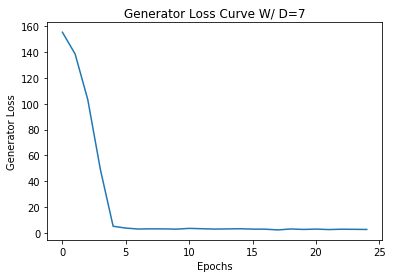

In [235]:
ax = plt.axes()
ax.set(xlabel="Epochs", ylabel="Generator Loss", Title="Generator Loss Curve W/ D=7")
ax.plot(range(NUM_TOTAL_ITER * NUM_EPOCHS_GEN), loss_by_epoch_g)

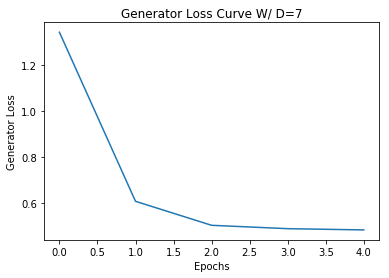

In [236]:
ax = plt.axes()
ax.set(xlabel="Epochs", ylabel="Generator Loss", Title="Generator Loss Curve W/ D=7")
ax.plot(range(NUM_TOTAL_ITER * NUM_EPOCHS_ADV), loss_by_epoch_a)

# Testing
## Test Adversary before and after decorrelation

In [237]:
out_class = model_adv(X_tensor.float())
v, i = torch.max(out_class, 1)
print((s_tensor.squeeze().int() == i.int()).nonzero().shape[0]/s_tensor.shape[0])

0.8570682718589724


In [238]:
gen_noised = model_gen(noised_tensor.float())

out_class = model_adv(gen_noised.float())
v, i = torch.max(out_class, 1)
print((s_tensor.squeeze().int() == i.int()).nonzero().shape[0]/s_tensor.shape[0])

0.8563619053468874


## Test Classifier Before and After Decorrelation

### Before

In [204]:
class_loader = torch.utils.data.DataLoader(
    torch.cat((X_tensor, y_tensor), 1), 
    batch_size=512, 
    shuffle=True)

for epoch in range(20):
    loss_avg = 0
    num = 0
    for batch in class_loader:
        x, y = batch[:, 0:-1], batch[:, -1]
        y_pred = model_class(x.float())

        loss = loss_class(y_pred, y.long())
        loss_avg += loss
        num += 1

        optim_class.zero_grad()
        loss.backward()
        optim_class.step()
    print("loss: ", (loss_avg/num).item())

loss:  0.7499217987060547
loss:  0.7505937814712524
loss:  0.7509123682975769
loss:  0.7507186532020569
loss:  0.7503775954246521
loss:  0.7497855424880981
loss:  0.7501169443130493
loss:  0.7505664825439453
loss:  0.7501558661460876
loss:  0.7504795789718628
loss:  0.7501490116119385
loss:  0.75031578540802
loss:  0.7502710223197937
loss:  0.750315248966217
loss:  0.7500293850898743
loss:  0.7500274777412415
loss:  0.7504754662513733
loss:  0.7498048543930054
loss:  0.7501707673072815
loss:  0.750838577747345


In [207]:
out_class = model_class(X_tensor.float())
v, i = torch.max(out_class, 1)
print((y_tensor.squeeze().int() == i.int()).nonzero().shape[0]/y_tensor.shape[0])

0.4322041706335801


### After

In [209]:
model_class = torch.nn.Sequential(
          # Layer 1 - 10 -> 128
          torch.nn.Linear(10, 128),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(128),
          # Layer 2 - 128 -> 256
          torch.nn.Linear(128, 256),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(256),
          # Layer 3 - 256 -> 256
          torch.nn.Linear(256, 256),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(256),
          # Layer 4 - 256 -> 128
          torch.nn.Linear(256, 128),
          torch.nn.LeakyReLU(),
          torch.nn.BatchNorm1d(128),
          # Output - 128 -> 2
          torch.nn.Linear(128, 2),
        ).to(device)

optim_class = torch.optim.Adam(model_class.parameters())
loss_class = torch.nn.CrossEntropyLoss()

gen_noised = model_gen(noised_tensor.float())

class_loader = torch.utils.data.DataLoader(
    torch.cat((gen_noised.float(), y_tensor.float()), 1), 
    batch_size=512, 
    shuffle=True)

for epoch in range(20):
    loss_avg = 0
    num = 0
    for batch in class_loader:
        x, y = batch[:, 0:-1], batch[:, -1]
        y_pred = model_class(x.float())

        loss = loss_class(y_pred, y.long())
        loss_avg += loss
        num += 1

        optim_class.zero_grad()
        loss.backward(retain_graph=True)
        optim_class.step()
    print("loss: ", (loss_avg/num).item())

loss:  0.5618746876716614


KeyboardInterrupt: 

In [ ]:
out_class = model_class(X_tensor.float())
v, i = torch.max(out_class, 1)
print((y_tensor.squeeze().int() == i.int()).nonzero().shape[0]/y_tensor.shape[0])